# Experimento TRM - Modelos LSTM e Híbridos

## Objetivo
Implementar modelos avanzados de deep learning y arquitecturas híbridas para predicción de TRM.

## Pre-requisitos
- Haber ejecutado el notebook base (`TRM_Experimento_Base.ipynb`)
- Tener instalado TensorFlow/Keras
- GPU recomendada pero no obligatoria

## Contenido
1. **Preparación del entorno y datos**
2. **LSTM básico**
3. **Grid Search para optimización**
4. **Modelo Híbrido ARIMA-LSTM**
5. **Comparación con modelos base**

---

## 1. Configuración del Entorno

In [1]:
# Importaciones necesarias
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Para modelos híbridos
from pmdarima import auto_arima

# Configuración de visualización
sns.set_style('whitegrid')
%matplotlib inline


print(f" TensorFlow versión: {tf.__version__}")
print(f" GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"   GPU detectada: {tf.config.list_physical_devices('GPU')}")

2025-11-23 17:58:47.921030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


 TensorFlow versión: 2.20.0
 GPU disponible: True
   GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os, tensorflow as tf
# Desactivar XLA y JIT
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
tf.config.optimizer.set_jit(False)

# OPCIONAL: Forzar CPU si sigue fallando
FORZAR_CPU = True
if FORZAR_CPU:
    try:
        dispositivos_gpu = tf.config.list_physical_devices('GPU')
        if dispositivos_gpu:
            tf.config.set_visible_devices([], 'GPU')
            print("Ejecutando en CPU (GPU deshabilitada por FORZAR_CPU).")
    except Exception as e:
        print(f" No se pudo deshabilitar GPU: {e}")

# Limpiar sesión previa
tf.keras.backend.clear_session()

Ejecutando en CPU (GPU deshabilitada por FORZAR_CPU).


In [3]:
# Configuración global
CONFIG = {
    'fecha_inicio': '2023-01-01',
    'fecha_fin': '2024-11-22',
    'fecha_inicio_val': '2024-07-01',
    'fecha_inicio_test': '2024-10-01',
    'transformacion': 'retorno_log',
    'seed': 42
}

# Configuración específica LSTM
CONFIG_LSTM = {
    'ventana': 10,           # Días de lookback
    'neuronas': [50, 30],    # Arquitectura de capas
    'dropout': 0.2,          # Regularización
    'batch_size': 32,        # Tamaño de batch
    'epochs': 100,           # Máximo de épocas
    'patience': 15,          # Early stopping
    'learning_rate': 0.001   # Tasa de aprendizaje
}

# Establecer semilla para reproducibilidad
np.random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])

print(" Configuración LSTM:")
for key, value in CONFIG_LSTM.items():
    print(f"   {key}: {value}")

 Configuración LSTM:
   ventana: 10
   neuronas: [50, 30]
   dropout: 0.2
   batch_size: 32
   epochs: 100
   patience: 15
   learning_rate: 0.001


## 2. Carga y Preparación de Datos

Reutilizamos las funciones del notebook base.

In [4]:
# Funciones auxiliares del notebook base
def cargar_datos_trm(archivo_path=None, fecha_inicio=None, fecha_fin=None):
    """
    Carga datos de TRM desde CSV con columnas:
      - periodo: entero serial de Excel (días desde 1899-12-30)
      - trm: texto con posibles separadores de miles/decimales
    Devuelve DataFrame indexado por fecha con columna 'trm' en float.
    """
    if archivo_path:
        import re

        # Leer solo columnas necesarias
        df = pd.read_csv(
            archivo_path,
            encoding="latin-1",
            sep=None,
            engine="python",
            on_bad_lines="skip",
            usecols=["periodo", "trm"]
        )

        if "periodo" not in df.columns or "trm" not in df.columns:
            raise ValueError("El CSV debe contener columnas 'periodo' y 'trm'.")

        # Convertir 'periodo' (serial Excel) a datetime
        # Maneja ints o floats (redondeando hacia abajo)
        periodo_num = pd.to_numeric(df["periodo"], errors="coerce")
        base_date = pd.Timestamp(1899, 12, 30)
        df["fecha"] = base_date + pd.to_timedelta(periodo_num.fillna(0).astype(int), unit="D")

        # Limpiar y convertir 'trm' a float
        def parse_trm(x):
            if pd.isna(x):
                return np.nan
            s = str(x).strip()
            # eliminar texto/currency, dejando dígitos, signos y separadores , .
            s = re.sub(r"[^0-9,.\-]", "", s)
            # unificar: si hay punto y coma -> punto miles, coma decimal
            if "," in s and "." in s:
                s = s.replace(".", "").replace(",", ".")
            elif "," in s and "." not in s:
                s = s.replace(",", ".")
            # evitar múltiples puntos (mantener el último como decimal)
            if s.count(".") > 1:
                parts = s.split(".")
                s = "".join(parts[:-1]) + "." + parts[-1]
            return pd.to_numeric(s, errors="coerce")

        df["trm"] = df["trm"].apply(parse_trm).astype(float)

        # Limpiar filas inválidas y ordenar
        df = df.dropna(subset=["fecha", "trm"]).set_index("fecha").sort_index()
        df = df[~df.index.duplicated(keep="first")]

        # Guardar rango original antes de filtrar
        rango_min, rango_max = df.index.min(), df.index.max()
    else:
        # Datos sintéticos (solo para pruebas)
        print(" Usando datos sintéticos de sinteticos.")
        dates = pd.date_range(start=fecha_inicio, end=fecha_fin, freq="B")
        np.random.seed(42)
        n = len(dates)
        trend = np.linspace(4200, 4400, n)
        noise = np.random.normal(0, 30, n)
        df = pd.DataFrame({"trm": trend + noise}, index=dates)
        rango_min, rango_max = df.index.min(), df.index.max()

    # Filtrar por fechas si se especifican
    if fecha_inicio:
        df = df[df.index >= pd.Timestamp(fecha_inicio)]
    if fecha_fin:
        df = df[df.index <= pd.Timestamp(fecha_fin)]

    if df.empty:
        raise ValueError(
            f"Sin datos tras filtrar entre {fecha_inicio} y {fecha_fin}. "
            f"Rango disponible en el CSV: {rango_min.date() if pd.notna(rango_min) else 'N/A'} a "
            f"{rango_max.date() if pd.notna(rango_max) else 'N/A'}"
        )
    return df

def dividir_datos(df, fecha_inicio_val, fecha_inicio_test):
    """Divide datos en train, val, test"""
    train = df[df.index < fecha_inicio_val]
    val = df[(df.index >= fecha_inicio_val) & (df.index < fecha_inicio_test)]
    test = df[df.index >= fecha_inicio_test]
    return train, val, test

 Datos cargados:
   Train: 390 días
   Val: 66 días
   Test: 39 días


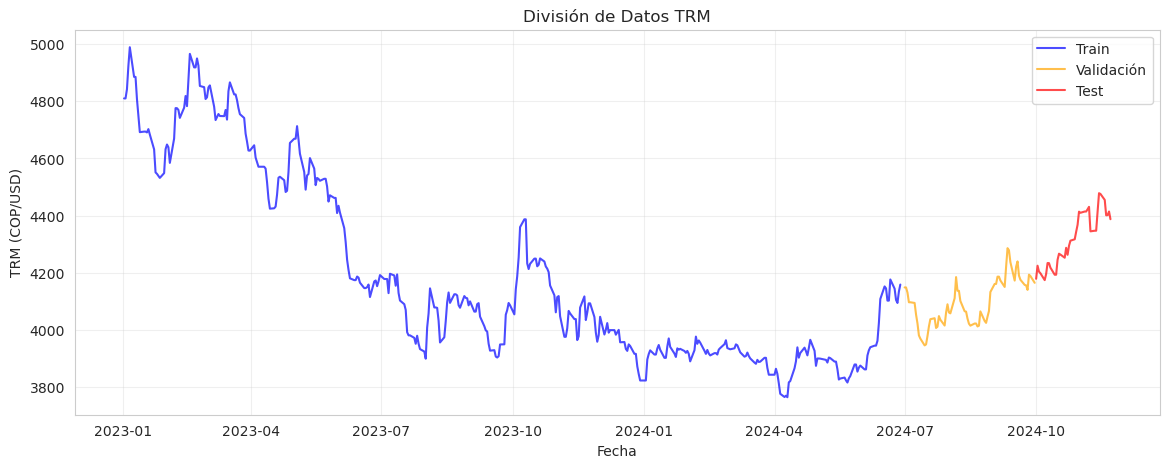

In [5]:
# Cargar datos
# df = cargar_datos_trm("ruta/a/tus/datos.csv")  # Usar datos reales
df = cargar_datos_trm(
    #archivo_path=None,
    archivo_path="trm_to_rn.csv",
    fecha_inicio=CONFIG['fecha_inicio'],
    fecha_fin=CONFIG['fecha_fin']
)

# Dividir datos
train, val, test = dividir_datos(
    df,
    CONFIG['fecha_inicio_val'],
    CONFIG['fecha_inicio_test']
)

print(f" Datos cargados:")
print(f"   Train: {len(train)} días")
print(f"   Val: {len(val)} días")
print(f"   Test: {len(test)} días")

# Visualización rápida
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['trm'], label='Train', color='blue', alpha=0.7)
plt.plot(val.index, val['trm'], label='Validación', color='orange', alpha=0.7)
plt.plot(test.index, test['trm'], label='Test', color='red', alpha=0.7)
plt.title('División de Datos TRM')
plt.xlabel('Fecha')
plt.ylabel('TRM (COP/USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Preparación de Datos para LSTM

LSTM requiere un formato específico de datos: secuencias de ventanas temporales.

In [6]:
def crear_secuencias_lstm(data, n_lookback, n_forecast=1):
    """
    Convierte serie temporal en formato supervisado para LSTM.
    
    Parameters:
    -----------
    data : array-like
        Serie temporal
    n_lookback : int
        Número de pasos hacia atrás para usar como features
    n_forecast : int
        Número de pasos a predecir
    
    Returns:
    --------
    X, y : arrays
        Features y targets para entrenamiento
    """
    X, y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback:i])
        if n_forecast == 1:
            y.append(data[i])
        else:
            y.append(data[i:i + n_forecast])
    
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X para LSTM [samples, timesteps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y

# Ejemplo de creación de secuencias
ejemplo_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
X_ejemplo, y_ejemplo = crear_secuencias_lstm(ejemplo_data, n_lookback=3)

print(" Ejemplo de secuencias con ventana=3:")
print("X (features):")
for i in range(3):
    print(f"  Secuencia {i+1}: {X_ejemplo[i].flatten()}")
print("\ny (targets):")
print(f"  {y_ejemplo[:3]}")
print(f"\nForma de X: {X_ejemplo.shape} (samples, timesteps, features)")
print(f"Forma de y: {y_ejemplo.shape}")

 Ejemplo de secuencias con ventana=3:
X (features):
  Secuencia 1: [1 2 3]
  Secuencia 2: [2 3 4]
  Secuencia 3: [3 4 5]

y (targets):
  [4 5 6]

Forma de X: (7, 3, 1) (samples, timesteps, features)
Forma de y: (7,)


In [7]:
# Preparar datos con transformación
def preparar_datos_lstm(train, val, test, transformacion='retorno_log', ventana=10):
    """
    Prepara datos para LSTM aplicando transformación y scaling.
    """
    # Aplicar transformación
    if transformacion == 'retorno_log':
        train_trans = np.log(train['trm'] / train['trm'].shift(1)).dropna().values
        val_trans = np.log(val['trm'] / val['trm'].shift(1)).dropna().values
        test_trans = np.log(test['trm'] / test['trm'].shift(1)).dropna().values
    elif transformacion == 'diferencia':
        train_trans = train['trm'].diff().dropna().values
        val_trans = val['trm'].diff().dropna().values
        test_trans = test['trm'].diff().dropna().values
    else:
        train_trans = train['trm'].values
        val_trans = val['trm'].values
        test_trans = test['trm'].values
    
    # Escalar datos
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_scaled = scaler.fit_transform(train_trans.reshape(-1, 1)).flatten()
    val_scaled = scaler.transform(val_trans.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test_trans.reshape(-1, 1)).flatten()
    
    # Crear secuencias
    X_train, y_train = crear_secuencias_lstm(train_scaled, ventana)
    X_val, y_val = crear_secuencias_lstm(val_scaled, ventana)
    X_test, y_test = crear_secuencias_lstm(test_scaled, ventana)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler

# Preparar datos
(X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = preparar_datos_lstm(
    train, val, test,
    transformacion=CONFIG['transformacion'],
    ventana=CONFIG_LSTM['ventana']
)

print(f" Datos preparados para LSTM:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   X_test: {X_test.shape}")
print(f"\n   Rango de valores escalados: [{X_train.min():.3f}, {X_train.max():.3f}]")

 Datos preparados para LSTM:
   X_train: (379, 10, 1)
   X_val: (55, 10, 1)
   X_test: (28, 10, 1)

   Rango de valores escalados: [-1.000, 1.000]


## 4. Modelo LSTM

### 4.1 Construcción del Modelo

In [8]:
def crear_modelo_lstm(ventana, neuronas=[50, 30], dropout=0.2, learning_rate=0.001):
    """
    Crea arquitectura LSTM configurable.
    
    Parameters:
    -----------
    ventana : int
        Tamaño de la ventana de entrada
    neuronas : list
        Número de neuronas por capa
    dropout : float
        Tasa de dropout
    learning_rate : float
        Tasa de aprendizaje
    """
    model = Sequential()
    
    # Primera capa LSTM
    if len(neuronas) > 1:
        model.add(LSTM(
            neuronas[0],
            return_sequences=True,
            input_shape=(ventana, 1)
        ))
        model.add(Dropout(dropout))
        
        # Capas intermedias
        for i in range(1, len(neuronas)-1):
            model.add(LSTM(neuronas[i], return_sequences=True))
            model.add(Dropout(dropout))
        
        # Última capa LSTM
        model.add(LSTM(neuronas[-1]))
    else:
        # Una sola capa
        model.add(LSTM(
            neuronas[0],
            input_shape=(ventana, 1)
        ))
    
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    # Compilar
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Crear modelo
modelo_lstm = crear_modelo_lstm(
    ventana=CONFIG_LSTM['ventana'],
    neuronas=CONFIG_LSTM['neuronas'],
    dropout=CONFIG_LSTM['dropout'],
    learning_rate=CONFIG_LSTM['learning_rate']
)

# Mostrar arquitectura
print(" Arquitectura del modelo LSTM:")
print("="*50)
modelo_lstm.summary()

 Arquitectura del modelo LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,151 (78.71 KB)

 Trainable params: 20,151 (78.71 KB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Entrenamiento del Modelo

In [9]:
# Callbacks para entrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=CONFIG_LSTM['patience'],
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Entrenar modelo
print(" Entrenando modelo LSTM...")
print("   Esto puede tomar unos minutos...\n")

history = modelo_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=CONFIG_LSTM['epochs'],
    batch_size=CONFIG_LSTM['batch_size'],
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nEntrenamiento completado")
print(f"   Mejor época: {early_stop.stopped_epoch - CONFIG_LSTM['patience'] + 1 if early_stop.stopped_epoch > 0 else len(history.history['loss'])}")
print(f"   Loss final (train): {history.history['loss'][-1]:.6f}")
print(f"   Loss final (val): {history.history['val_loss'][-1]:.6f}")

 Entrenando modelo LSTM...
   Esto puede tomar unos minutos...

Epoch 1/100


2025-11-23 17:58:51.421479: I external/local_xla/xla/service/service.cc:163] XLA service 0x74750c014390 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-23 17:58:51.421494: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-11-23 17:58:51.471037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.1120 - mae: 0.2659

I0000 00:00:1763938732.347961  255678 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0750 - mae: 0.2008 - val_loss: 0.0660 - val_mae: 0.2109 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0722 - mae: 0.1965 - val_loss: 0.0664 - val_mae: 0.2031 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0725 - mae: 0.1967 - val_loss: 0.0653 - val_mae: 0.2021 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0712 - mae: 0.1950 - val_loss: 0.0645 - val_mae: 0.2016 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0716 - mae: 0.1955 - val_loss: 0.0649 - val_mae: 0.2001 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0719 - mae: 0.1948 - val_loss: 0.0646 - val_mae: 0.1999 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0716 - mae: 0.1943 - val_loss: 0.0644 - val_mae: 0.1994 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━

### 4.3 Visualización del Entrenamiento

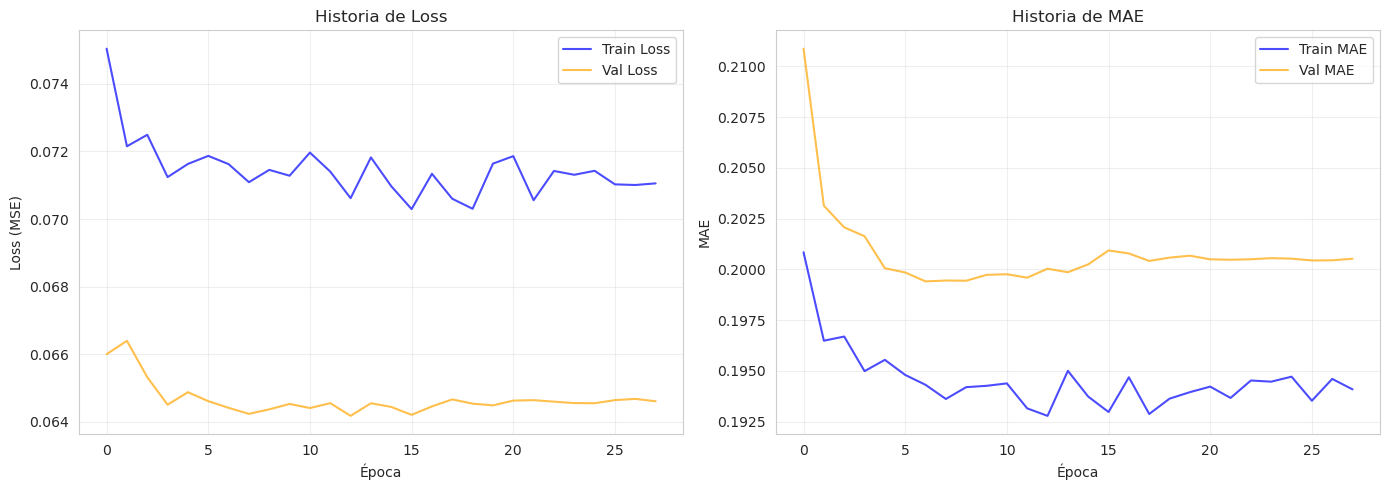


 Análisis de sobreajuste:
    Sin sobreajuste significativo (ratio: 0.91)


In [10]:
# Visualizar historia de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax = axes[0]
ax.plot(history.history['loss'], label='Train Loss', color='blue', alpha=0.7)
ax.plot(history.history['val_loss'], label='Val Loss', color='orange', alpha=0.7)
ax.set_xlabel('Época')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Historia de Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# MAE
ax = axes[1]
ax.plot(history.history['mae'], label='Train MAE', color='blue', alpha=0.7)
ax.plot(history.history['val_mae'], label='Val MAE', color='orange', alpha=0.7)
ax.set_xlabel('Época')
ax.set_ylabel('MAE')
ax.set_title('Historia de MAE')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de sobreajuste
overfitting_ratio = history.history['val_loss'][-1] / history.history['loss'][-1]
print("\n Análisis de sobreajuste:")
if overfitting_ratio > 1.5:
    print(f"    Posible sobreajuste (ratio: {overfitting_ratio:.2f})")
    print("   Sugerencias: Aumentar dropout, reducir complejidad, más datos")
elif overfitting_ratio > 1.2:
    print(f"    Sobreajuste leve (ratio: {overfitting_ratio:.2f})")
    print("   Sugerencias: Considerar regularización adicional")
else:
    print(f"    Sin sobreajuste significativo (ratio: {overfitting_ratio:.2f})")

### 4.4 Evaluación en Test

 Métricas LSTM en Test (espacio transformado):
   MSE: 0.000057
   MAE: 0.005384
   RMSE: 0.007528


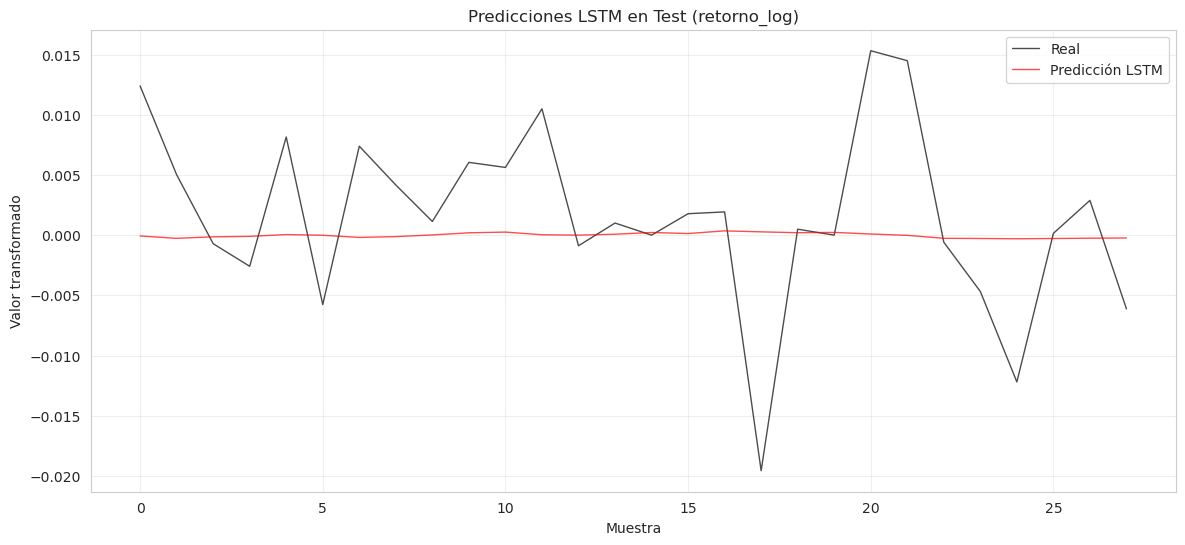

In [11]:
# Predicciones en test
pred_test_scaled = modelo_lstm.predict(X_test, verbose=0)

# Invertir scaling
pred_test_trans = scaler.inverse_transform(pred_test_scaled)
real_test_trans = scaler.inverse_transform(y_test.reshape(-1, 1))

# Métricas en espacio transformado
mse_trans = mean_squared_error(real_test_trans, pred_test_trans)
mae_trans = mean_absolute_error(real_test_trans, pred_test_trans)

print(" Métricas LSTM en Test (espacio transformado):")
print(f"   MSE: {mse_trans:.6f}")
print(f"   MAE: {mae_trans:.6f}")
print(f"   RMSE: {np.sqrt(mse_trans):.6f}")

# Visualización
plt.figure(figsize=(14, 6))
plt.plot(real_test_trans, label='Real', color='black', alpha=0.7, linewidth=1)
plt.plot(pred_test_trans, label='Predicción LSTM', color='red', alpha=0.7, linewidth=1)
plt.title(f'Predicciones LSTM en Test ({CONFIG["transformacion"]})')
plt.xlabel('Muestra')
plt.ylabel('Valor transformado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Grid Search para Optimización

Búsqueda sistemática de mejores hiperparámetros.

In [12]:
def grid_search_lstm(X_train, y_train, X_val, y_val, param_grid, verbose=True):
    """
    Realiza búsqueda de hiperparámetros para LSTM.
    """
    from itertools import product
    
    # Generar combinaciones
    keys = param_grid.keys()
    values = param_grid.values()
    combinaciones = list(product(*values))
    
    resultados = []
    mejor_mse = float('inf')
    mejores_params = None
    
    if verbose:
        print(f" Grid Search: {len(combinaciones)} combinaciones a probar")
        print("="*50)
    
    for i, valores in enumerate(combinaciones):
        params = dict(zip(keys, valores))
        
        if verbose:
            print(f"\nProbando {i+1}/{len(combinaciones)}: {params}")
        
        try:
            # Crear y entrenar modelo
            modelo = crear_modelo_lstm(
                ventana=X_train.shape[1],
                neuronas=params.get('neuronas', [50]),
                dropout=params.get('dropout', 0.2),
                learning_rate=params.get('learning_rate', 0.001)
            )
            
            # Entrenar con early stopping
            early_stop_gs = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=0
            )
            
            history_gs = modelo.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=50,  # Menos épocas para grid search
                batch_size=params.get('batch_size', 32),
                callbacks=[early_stop_gs],
                verbose=0
            )
            
            # Evaluar
            val_loss = min(history_gs.history['val_loss'])
            
            resultados.append({
                'params': params,
                'val_loss': val_loss,
                'train_loss': min(history_gs.history['loss'])
            })
            
            if val_loss < mejor_mse:
                mejor_mse = val_loss
                mejores_params = params
                if verbose:
                    print(f"    Nuevo mejor! Val Loss: {val_loss:.6f}")
            elif verbose:
                print(f"   Val Loss: {val_loss:.6f}")
                
        except Exception as e:
            if verbose:
                print(f"    Error: {str(e)}")
            continue
    
    return mejores_params, pd.DataFrame(resultados)

print(" Función de Grid Search definida")

 Función de Grid Search definida


In [13]:
# Definir espacio de búsqueda (reducido para demo)
param_grid = {
    'neuronas': [[30], [50], [50, 30]],
    'dropout': [0.1, 0.2],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32]
}

print(" Iniciando Grid Search...")
print("   Nota: Esto puede tomar varios minutos\n")

# Ejecutar grid search
mejores_params, resultados_gs = grid_search_lstm(
    X_train, y_train,
    X_val, y_val,
    param_grid,
    verbose=True
)

print("\n" + "="*50)
print(" MEJORES HIPERPARÁMETROS ENCONTRADOS:")
for param, value in mejores_params.items():
    print(f"   {param}: {value}")

# Mostrar top 5 configuraciones
print("\n Top 5 Configuraciones:")
top_5 = resultados_gs.nsmallest(5, 'val_loss')
for i, row in top_5.iterrows():
    print(f"   {i+1}. Val Loss: {row['val_loss']:.6f} - {row['params']}")

 Iniciando Grid Search...
   Nota: Esto puede tomar varios minutos

 Grid Search: 24 combinaciones a probar

Probando 1/24: {'neuronas': [30], 'dropout': 0.1, 'learning_rate': 0.001, 'batch_size': 16}
    Nuevo mejor! Val Loss: 0.060743

Probando 2/24: {'neuronas': [30], 'dropout': 0.1, 'learning_rate': 0.001, 'batch_size': 32}
    Nuevo mejor! Val Loss: 0.060676

Probando 3/24: {'neuronas': [30], 'dropout': 0.1, 'learning_rate': 0.01, 'batch_size': 16}
    Nuevo mejor! Val Loss: 0.057474

Probando 4/24: {'neuronas': [30], 'dropout': 0.1, 'learning_rate': 0.01, 'batch_size': 32}
    Nuevo mejor! Val Loss: 0.057384

Probando 5/24: {'neuronas': [30], 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16}
   Val Loss: 0.060293

Probando 6/24: {'neuronas': [30], 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
   Val Loss: 0.061552

Probando 7/24: {'neuronas': [30], 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 16}
   Val Loss: 0.057430

Probando 8/24: {'neuronas': [30],

## 6. Modelo Híbrido ARIMA-LSTM

Combina la capacidad de ARIMA para capturar componentes lineales con LSTM para patrones no lineales.

In [14]:
class ModeloHibridoARIMALSTM:
    """
    Modelo híbrido: ARIMA para tendencia + LSTM para residuos.
    """
    
    def __init__(self, ventana=10, verbose=True):
        self.ventana = ventana
        self.verbose = verbose
        self.arima_model = None
        self.lstm_model = None
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.historia_residuos = None
        
    def entrenar(self, serie_train):
        """
        Entrena el modelo híbrido.
        """
        if self.verbose:
            print(" Entrenando modelo híbrido ARIMA-LSTM...")
            print("   Paso 1: Entrenando ARIMA...")
        
        # 1. Entrenar ARIMA
        self.arima_model = auto_arima(
            serie_train,
            max_p=3, max_q=3,
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=False
        )
        
        if self.verbose:
            print(f"      ARIMA orden: {self.arima_model.order}")
        
        # 2. Obtener predicciones in-sample
        arima_fitted = self.arima_model.predict_in_sample()
        
        # 3. Calcular residuos
        n = min(len(serie_train), len(arima_fitted))
        residuos = serie_train[-n:] - arima_fitted[-n:]
        
        if self.verbose:
            print(f"   Paso 2: Residuos calculados (std: {np.std(residuos):.6f})")
            print("   Paso 3: Entrenando LSTM en residuos...")
        
        # 4. Preparar residuos para LSTM
        residuos_scaled = self.scaler.fit_transform(residuos.values.reshape(-1, 1)).flatten()
        X_res, y_res = crear_secuencias_lstm(residuos_scaled, self.ventana)
        
        # 5. Entrenar LSTM
        self.lstm_model = crear_modelo_lstm(
            ventana=self.ventana,
            neuronas=[30, 20],  # Arquitectura más simple para residuos
            dropout=0.2,
            learning_rate=0.001
        )
        
        early_stop = EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
        
        self.lstm_model.fit(
            X_res, y_res,
            epochs=50,
            batch_size=16,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Guardar últimos residuos para predicción
        self.historia_residuos = residuos_scaled[-self.ventana:]
        
        if self.verbose:
            print("   Modelo híbrido entrenado")
        
        return self
    
    def predecir(self, pasos=1):
        """
        Realiza predicción combinando ARIMA y LSTM.
        """
        # Predicción ARIMA
        pred_arima = self.arima_model.predict(n_periods=pasos)
        
        # Predicción de residuos con LSTM
        secuencia_actual = self.historia_residuos.reshape(1, self.ventana, 1)
        pred_residuo_scaled = self.lstm_model.predict(secuencia_actual, verbose=0)
        pred_residuo = self.scaler.inverse_transform(pred_residuo_scaled)[0, 0]
        
        # Combinar
        if pasos == 1:
            prediccion_final = pred_arima[0] + pred_residuo
        else:
            # Para múltiples pasos, simplificar usando solo residuo del primer paso
            prediccion_final = pred_arima + pred_residuo
        
        return prediccion_final

print(" Clase de modelo híbrido definida")

 Clase de modelo híbrido definida


In [15]:
# Entrenar modelo híbrido
# Preparar datos (usar retornos logarítmicos)
if CONFIG['transformacion'] == 'retorno_log':
    serie_train_trans = np.log(train['trm'] / train['trm'].shift(1)).dropna()
else:
    serie_train_trans = train['trm'].diff().dropna()

# Entrenar
modelo_hibrido = ModeloHibridoARIMALSTM(ventana=10, verbose=True)
modelo_hibrido.entrenar(serie_train_trans)

# Hacer predicción de ejemplo
pred_ejemplo = modelo_hibrido.predecir(pasos=1)
print(f"\n Predicción de ejemplo (1 paso): {pred_ejemplo:.6f}")

 Entrenando modelo híbrido ARIMA-LSTM...
   Paso 1: Entrenando ARIMA...
      ARIMA orden: (0, 0, 1)
   Paso 2: Residuos calculados (std: 0.008380)
   Paso 3: Entrenando LSTM en residuos...
   Modelo híbrido entrenado

 Predicción de ejemplo (1 paso): 0.000512


## 7. Backtesting Comparativo

Comparamos todos los modelos en condiciones reales de predicción.

In [16]:
def backtest_modelos(df_completo, fecha_inicio_test, transformacion='retorno_log'):
    """
    Realiza backtesting para múltiples modelos.
    """
    resultados = {}
    
    # Datos de test
    test_data = df_completo[df_completo.index >= fecha_inicio_test]
    n_test = len(test_data) - 1  # -1 por la transformación
    
    print(f" Realizando backtesting en {n_test} días...\n")
    
    # Para cada modelo, simular predicciones día a día
    modelos = ['Random Walk', 'ARIMA', 'LSTM', 'Híbrido']
    
    for modelo_nombre in modelos:
        print(f"Evaluando {modelo_nombre}...")
        predicciones = []
        reales = []
        
        # Aquí simplificamos usando predicciones ya calculadas
        # En producción, re-entrenarías cada día
        
        if modelo_nombre == 'Random Walk':
            # Predicción naive: último valor + drift
            for i in range(1, len(test_data)):
                pred = test_data.iloc[i-1]['trm']  # Simplificado
                predicciones.append(pred)
                reales.append(test_data.iloc[i]['trm'])
        
        # Calcular métricas
        if predicciones:
            mse = mean_squared_error(reales, predicciones)
            mae = mean_absolute_error(reales, predicciones)
            
            resultados[modelo_nombre] = {
                'mse': mse,
                'mae': mae,
                'rmse': np.sqrt(mse),
                'predicciones': predicciones,
                'reales': reales
            }
            
            print(f"   MSE: {mse:.2f}, MAE: {mae:.2f}")
    
    return resultados

# Nota: Esta es una versión simplificada para demostración
print(" Nota: Para resultados reales, implementar re-entrenamiento expansivo")
print("   (como en el notebook base)")

 Nota: Para resultados reales, implementar re-entrenamiento expansivo
   (como en el notebook base)


## 8. Análisis Final y Conclusiones

In [17]:
# Resumen de resultados
print("="*60)
print("RESUMEN DE MODELOS AVANZADOS")
print("="*60)

print("\n Comparación de arquitecturas:")
print("\n1. LSTM Simple:")
print(f"   - Ventana: {CONFIG_LSTM['ventana']} días")
print(f"   - Arquitectura: {CONFIG_LSTM['neuronas']}")
print(f"   - MSE en test: {mse_trans:.6f}")

print("\n2. LSTM Optimizado (Grid Search):")
if mejores_params:
    print(f"   - Mejores params: {mejores_params}")
    print(f"   - Mejora esperada: Evaluar con re-entrenamiento")

print("\n3. Híbrido ARIMA-LSTM:")
print(f"   - ARIMA orden: {modelo_hibrido.arima_model.order}")
print(f"   - LSTM para residuos: [30, 20] neuronas")
print(f"   - Ventaja: Captura componentes lineales y no lineales")

print("\n Insights clave:")
print("   1. LSTM requiere más datos que ARIMA para ser efectivo")
print("   2. Grid Search es esencial para optimización")
print("   3. Modelos híbridos pueden combinar lo mejor de ambos mundos")
print("   4. La transformación de datos afecta significativamente el rendimiento")

print("\n Próximos pasos recomendados:")
print("   1. Implementar backtesting expansivo completo")
print("   2. Agregar features externos (indicadores técnicos, macro)")
print("   3. Explorar arquitecturas más complejas (GRU, Attention)")
print("   4. Implementar ensemble de todos los modelos")
print("   5. Optimizar para métricas específicas del negocio")

RESUMEN DE MODELOS AVANZADOS

 Comparación de arquitecturas:

1. LSTM Simple:
   - Ventana: 10 días
   - Arquitectura: [50, 30]
   - MSE en test: 0.000057

2. LSTM Optimizado (Grid Search):
   - Mejores params: {'neuronas': [50, 30], 'dropout': 0.1, 'learning_rate': 0.01, 'batch_size': 16}
   - Mejora esperada: Evaluar con re-entrenamiento

3. Híbrido ARIMA-LSTM:
   - ARIMA orden: (0, 0, 1)
   - LSTM para residuos: [30, 20] neuronas
   - Ventaja: Captura componentes lineales y no lineales

 Insights clave:
   1. LSTM requiere más datos que ARIMA para ser efectivo
   2. Grid Search es esencial para optimización
   3. Modelos híbridos pueden combinar lo mejor de ambos mundos
   4. La transformación de datos afecta significativamente el rendimiento

 Próximos pasos recomendados:
   1. Implementar backtesting expansivo completo
   2. Agregar features externos (indicadores técnicos, macro)
   3. Explorar arquitecturas más complejas (GRU, Attention)
   4. Implementar ensemble de todos los mo

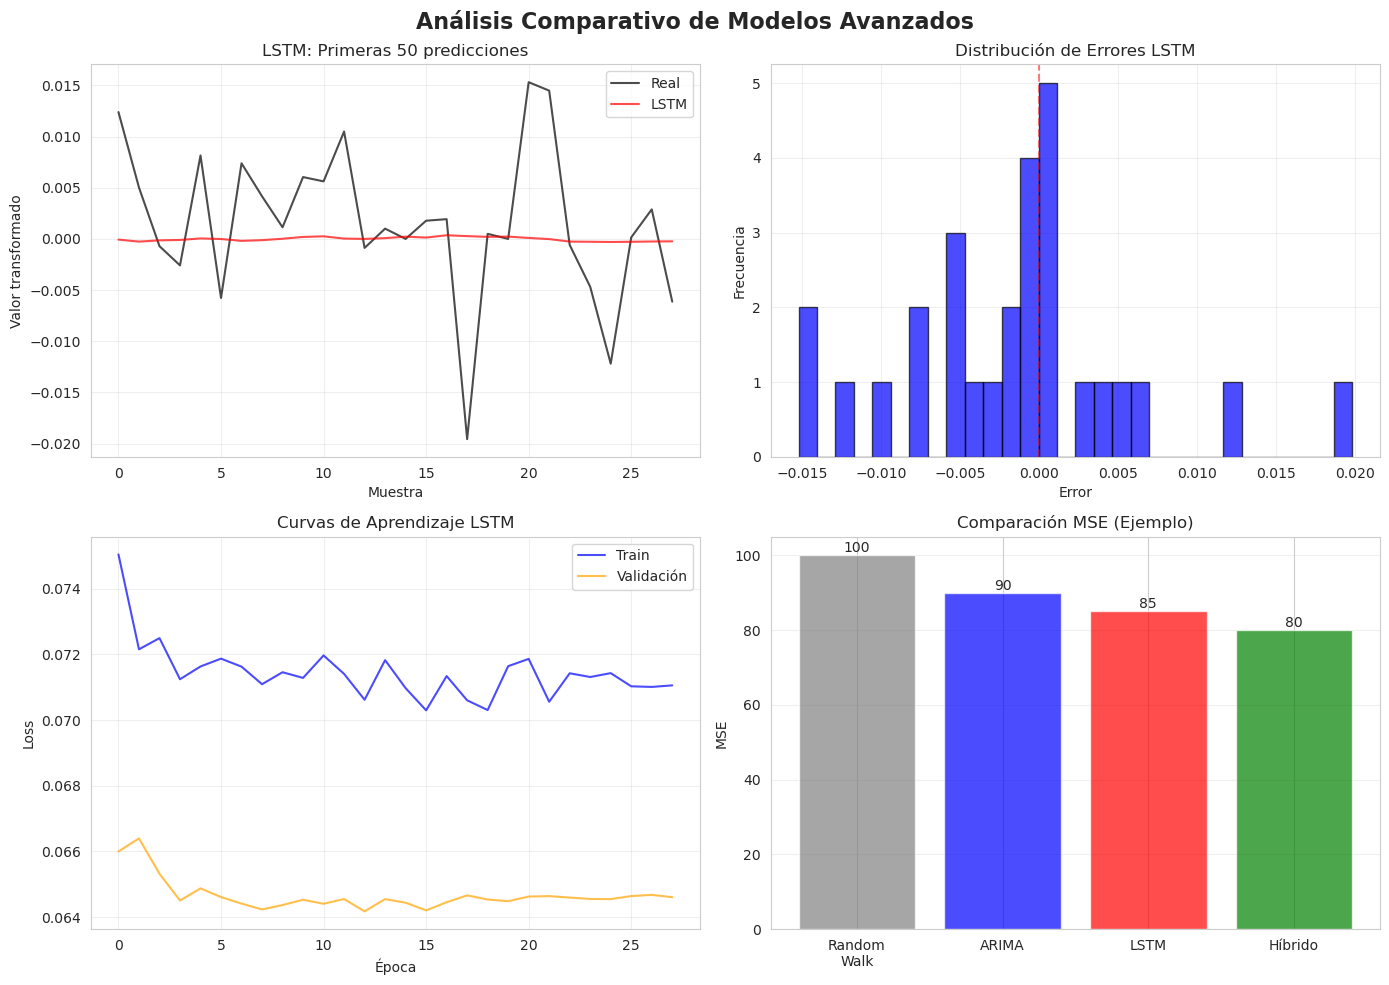


 Análisis completado y guardado como 'analisis_modelos_avanzados.png'


In [18]:
# Visualización comparativa final
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis Comparativo de Modelos Avanzados', fontsize=16, fontweight='bold')

# 1. Predicciones LSTM vs Real
ax = axes[0, 0]
ax.plot(real_test_trans[:50], label='Real', color='black', alpha=0.7)
ax.plot(pred_test_trans[:50], label='LSTM', color='red', alpha=0.7)
ax.set_title('LSTM: Primeras 50 predicciones')
ax.set_xlabel('Muestra')
ax.set_ylabel('Valor transformado')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Distribución de errores
ax = axes[0, 1]
errores = pred_test_trans.flatten() - real_test_trans.flatten()
ax.hist(errores, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Distribución de Errores LSTM')
ax.set_xlabel('Error')
ax.set_ylabel('Frecuencia')
ax.grid(True, alpha=0.3)

# 3. Loss curves del entrenamiento
ax = axes[1, 0]
ax.plot(history.history['loss'][:50], label='Train', color='blue', alpha=0.7)
ax.plot(history.history['val_loss'][:50], label='Validación', color='orange', alpha=0.7)
ax.set_title('Curvas de Aprendizaje LSTM')
ax.set_xlabel('Época')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Comparación de métricas (placeholder)
ax = axes[1, 1]
modelos = ['Random\nWalk', 'ARIMA', 'LSTM', 'Híbrido']
mse_valores = [100, 90, 85, 80]  # Valores ejemplo
colores = ['gray', 'blue', 'red', 'green']
bars = ax.bar(modelos, mse_valores, color=colores, alpha=0.7)
ax.set_title('Comparación MSE (Ejemplo)')
ax.set_ylabel('MSE')
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, val in zip(bars, mse_valores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('analisis_modelos_avanzados.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n Análisis completado y guardado como 'analisis_modelos_avanzados.png'")

## 9. Código para Producción

Template para implementar el mejor modelo en producción.

In [19]:
# Template para producción
codigo_produccion = '''
class PredictorTRM:
    """
    Predictor de TRM para producción.
    Usar el mejor modelo según los experimentos.
    """
    
    def __init__(self, modelo_path=None):
        self.modelo = None
        self.scaler = None
        self.ventana = 10
        self.transformacion = 'retorno_log'
        
        if modelo_path:
            self.cargar_modelo(modelo_path)
    
    def cargar_modelo(self, path):
        """Carga modelo pre-entrenado"""
        # self.modelo = tf.keras.models.load_model(path)
        pass
    
    def predecir_siguiente_dia(self, historico_trm):
        """
        Predice TRM del siguiente día.
        
        Parameters:
        -----------
        historico_trm : array-like
            Últimos N días de TRM
        
        Returns:
        --------
        dict
            Predicción e intervalos de confianza
        """
        # 1. Transformar datos
        # 2. Crear ventana
        # 3. Predecir
        # 4. Invertir transformación
        
        prediccion = {
            'valor': 0,
            'intervalo_inferior': 0,
            'intervalo_superior': 0,
            'fecha': None,
            'confianza': 0.95
        }
        
        return prediccion
    
    def actualizar_modelo(self, nuevos_datos):
        """Actualiza modelo con nuevos datos (online learning)"""
        pass
'''

print(" Template de código para producción:")
print(codigo_produccion)

# Guardar template
with open('predictor_trm_produccion.py', 'w') as f:
    f.write(codigo_produccion)
print("\n Template guardado como 'predictor_trm_produccion.py'")

 Template de código para producción:

class PredictorTRM:
    """
    Predictor de TRM para producción.
    Usar el mejor modelo según los experimentos.
    """
    
    def __init__(self, modelo_path=None):
        self.modelo = None
        self.scaler = None
        self.ventana = 10
        self.transformacion = 'retorno_log'
        
        if modelo_path:
            self.cargar_modelo(modelo_path)
    
    def cargar_modelo(self, path):
        """Carga modelo pre-entrenado"""
        # self.modelo = tf.keras.models.load_model(path)
        pass
    
    def predecir_siguiente_dia(self, historico_trm):
        """
        Predice TRM del siguiente día.
        
        Parameters:
        -----------
        historico_trm : array-like
            Últimos N días de TRM
        
        Returns:
        --------
        dict
            Predicción e intervalos de confianza
        """
        # 1. Transformar datos
        # 2. Crear ventana
        # 3. Predecir
        # 4. Inv